## 此样例是二分类问题，建立带有一个包含四个神经元的隐藏层的神经网络
与binary classification sample1相比，本例使用``tf.data.Dataset``
### 输入
x1, x2
### 输出
y = x1 + x2 >= 0? 1: 0

In [11]:
import tensorflow as tf
import numpy as np
import math

BATCH_SIZE = 32
TRAINING_SAMPLE_NUM = 1000
VALIDATING_SAMPLE_NUM = 100
EPOCH = 10

### 产生训练数据
使用``np.random.randn``随机生成满足正态分布的数组，size为1000 * 2，即1000个样例，每个样例2个特征，并生成对应的label

In [12]:
x = np.random.randn(TRAINING_SAMPLE_NUM, 2)
y = np.zeros((TRAINING_SAMPLE_NUM, 1))
y[np.sum(x, axis=1) >= 0] = 1

### 产生验证集数据
用相同的方法产生验证集，共100个样例

In [13]:
val_x = np.random.randn(VALIDATING_SAMPLE_NUM, 2)
val_y = np.zeros((VALIDATING_SAMPLE_NUM, 1))
val_y[np.sum(val_x, axis=1) >= 0] = 1

### 将数据变为Dataset类型
同时设置BATCH_SIZE大小、shuffle、repeat
* batch方法的参数batch_size代表要输出的每个batch有多少条数据组成。如果数据集中包含多个张量，那么batch操作将对每一个张量分开进行。例如，如果数据集中的每一个数据是image、label两个张量，其中image的维度是[300, 300]，label的维度是[]，batch_size是128，那么经过batch操作后的数据集的每一个输出将包含两个维度分别是[128, 300, 300]和[128]的张量； 
* shuffle方法参数为buffer_size，此算法在内部使用一个缓冲区保存buffer_size条数据，每读入一条新数据时，从这个缓冲区中随机选择一条数据进行输出。缓冲区的大小越大，随机的性能越好，单占用的内存也越多；
* repeat方法将数据集中的数据复制多份，其中每一份数据被称为一个epoch。如果数据集在repeat前已经进行了shuffle操作，输出的每个epoch中随机shuffle的结果并不会相同。repeat只代表重复相同的处理过程，并不会记录前一epoch的处理结果。

> 以上内容摘自《TensorFlow实战Google深度学习框架（第二版）》（郑泽宇、梁博文、顾思宇著）

之后查看样例数据维度，作为网络第一层的input_shape参数

验证集只需要设置BATCH_SIZE，不需要shuffle和repeat

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((x, y))
# 查看样例数据维度
for d, l in train_dataset.take(1):
    break
print('样例数据维度为：{}'.format(d.numpy().shape))

train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(TRAINING_SAMPLE_NUM).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_dataset = val_dataset.batch(BATCH_SIZE)
type(train_dataset), type(val_dataset)

样例数据维度为：(2,)


(tensorflow.python.data.ops.dataset_ops.RepeatDataset,
 tensorflow.python.data.ops.dataset_ops.BatchDataset)

In [16]:
isinstance(train_dataset, tf.data.Dataset)

True

## 创建模型
创建带有一个包含四个神经元的隐藏层的神经网络
### 建立两层神经元
* 第一层：隐藏层，四个神经元。使用ReLU激活函数；
* 第二层：输出层，一个神经元。使用sigmoid激活函数；
使用``tf.keras.layers.Dense``建立网络层，此方法的两个参数为：
* ``input_shape=[1]`` 表示此层输入的维度。
* ``units=1`` 表示此层中神经元的数量，应该与下一层的``input_shape``相同

### 编译模型
使用``model.compile``对模型进行编译，此方法的三个参数为：
* ``loss``为损失函数，``tf.keras.losses.binary_crossentropy``为二分类问题中的逻辑回归损失函数。也可以使用``'binary_crossentropy'``（字符串）或``tf.keras.losses.BinaryCrossentropy()``（注意要带括号）
* ``optimizer``为优化方法，此处使用``Adam``
* ``metrics``为评估方法，``tf.keras.metrics.binary_accuracy``为二分类准确率，``tf.keras.metrics.AUC()``为AUC（注意要带括号）

In [18]:
l0 = tf.keras.layers.Dense(units=4, input_shape=[2], activation='relu')
l1 = tf.keras.layers.Dense(units=1, activation='sigmoid')
model = tf.keras.Sequential([l0, l1])
model.compile(loss=tf.keras.losses.binary_crossentropy,
             optimizer=tf.keras.optimizers.Adam(0.01),
             metrics=[tf.keras.metrics.binary_accuracy, tf.keras.metrics.AUC()])

## 训练模型
* ``epochs``代表将整个训练集循环多少次，此例中对训练集数据循环训练了10次
* ``steps_per_epoch``表示每次训练中的训练step数量，每一step从训练集中取出BATCH_SIZE个样本进行训练

In [19]:
history = model.fit(train_dataset, epochs=EPOCH, steps_per_epoch=math.ceil(TRAINING_SAMPLE_NUM / BATCH_SIZE), verbose=1)

W0724 09:59:53.766268  9088 deprecation.py:323] From C:\Users\arsener\PycharmProjects\tensorflow2.0beta\venv\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
32/32 [==============================] - 1s 30ms/step - loss: 0.6076 - binary_accuracy: 0.5550 - auc_2: 0.8066
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4482 - binary_accuracy: 0.9040 - auc_2: 0.9975
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.3463 - binary_accuracy: 0.9630 - auc_2: 0.9994
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: 0.2548 - binary_accuracy: 0.9780 - auc_2: 0.9992
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1752 - binary_accuracy: 0.9860 - auc_2: 0.9994
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1181 - binary_accuracy: 0.9930 - auc_2: 0.9998
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0855 - binary_accuracy: 0.9970 - auc_2: 1.0000
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0704 - binary_accuracy: 0.9970 - auc_2: 0.9999
Epoch 9/10
32/32 [=============

## 分别展示loss、预测准确率、AUC随epoch的变化情况

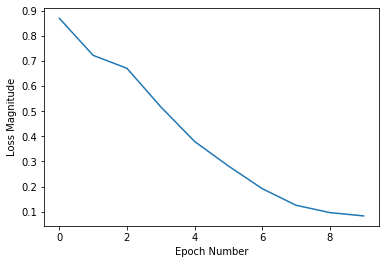

In [76]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['loss'])
plt.show()

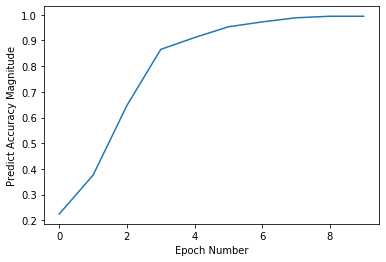

In [77]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("Predict Accuracy Magnitude")
plt.plot(history.history['binary_accuracy'])
plt.show()

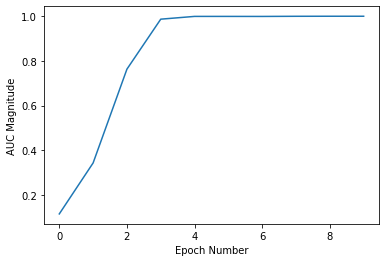

In [78]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("AUC Magnitude")
plt.plot(history.history['auc_5'])
plt.show()

## 进行评估
使用``model.evaluate``方法对验证集进行评估

传入``np.array``进行评估

In [79]:
model.evaluate(val_x, val_y, verbose=1)

100/100 [==============================] - 0s 2ms/sample - loss: 0.0790 - binary_accuracy: 0.9900 - auc_5: 1.0000


[0.07904539987444878, 0.99, 0.99999994]

传入``tf.data.Dataset``进行评估，评估时``BATCH_SIZE``为之前设置的32，为了将验证集中所有数据全部进行验证，需要设置

> steps=math.ceil(VALIDATING_SAMPLE_NUM / BATCH_SIZE)

In [94]:
val_loss, val_accuracy, val_auc =model.evaluate(val_dataset, steps=math.ceil(VALIDATING_SAMPLE_NUM / BATCH_SIZE))

4/4 [==============================] - 0s 3ms/step - loss: 0.0687 - binary_accuracy: 0.9900 - auc_5: 1.0000


In [95]:
print('The loss, accuracy and auc are respectively {0:.4f}, {1:.4f} and {2:.4f}'.format(val_loss, val_accuracy, val_auc))

The loss, accuracy and auc are respectively 0.0687, 0.9900 and 1.0000
